In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pydotplus 
import pandas as pd

from IPython.display import Image
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cross_validation import cross_val_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline

### Теоретические задачи

#### #1

В задаче регрессии в лист попадают объекты выборки $X_1, X_2, ..., X_n$ с целевыми переменными $y_1, y_2, ..., y_n$.
<br> В первом случае оценкой является $M = \frac{1}{n}\sum_{i=1}^{n}{y_i}$.
<br> Во втором - $\xi$ с равномерным дискретным распределением на $y_1, y_2, ..., y_n$.
<br> Оценим матожидание $MSE$, обозначим $\widehat{y}$ оценку в общем случае, тогда:
<br> $E(\sum_{i=1}^{n}(\widehat{y} - y_i)^2) = \sum_{i=1}^{n}E(\widehat{y} - y_i)^2 = \sum_{i=1}^{n}Ey_i^2-2Ey_i\widehat{y} + \sum_{i=1}^{n}\widehat{y}$
<br> Посмотрим на слагамые в случае 1-ой и 2-ой оценок:
<br> 1-ое слагаемое независит от оценок, поэтому одинаковое в обоих случаях
<br> 2-ое слагаемое в первом случае $EM = M$, а во втором $E\frac{1}{n}\sum_{i=1}^{n}{y_i} = EM = M$
<br> 3-e слагаемое в первом случае: $EM^2 = M^2$, а во втором $E\xi^2$, но $E\xi^2 >= (E\xi)^2 = M^2$,
<br> таким образом во втором случае матожидание MSE не меньше, чем в первом, то есть оптимальнее отвечать средним значением.

#### #2

#### #3

Формула плотности многомерного нормального распределения:
<br> $p(x) = \frac{\displaystyle1}{\displaystyle(2\pi)^{n/2}|\Sigma|^{0.5}}e ^{-0.5(x-\mu)^T\Sigma^{-1}(x-\mu)} $,
<br> в таком случе энтропия нормального распределения:
<br> H(p) = $\displaystyle-\int...\int p(x)ln(p(x))dx = \displaystyle\int...\int p(x)(\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu) + ln((2\pi)^{n/2}|\Sigma|^{0.5}))dx=$
<br> $=\displaystyle \frac{1}{2}\displaystyle\Sigma_{ij}(E((x_i-\mu_i)(x_j-\mu_j))(\Sigma^{-1}_{ij})) + \frac{1}{2}ln((2\pi)^n|\Sigma|)= \frac{1}{2}\Sigma_i\Sigma_j(\Sigma)_{i,j}(\Sigma^{-1})_{i,j}+ \frac{1}{2}ln((2\pi)^n|\Sigma|) = $
<br> $=\displaystyle \frac{1}{2}\Sigma_i(\Sigma\Sigma^{-1})_{i,i}+ \frac{1}{2}ln((2\pi)^n|\Sigma|) = \frac{1}{2}\Sigma_i(E)_{i,i} + \frac{1}{2}ln((2\pi)^n|\Sigma|) = \frac{n}{2} + \frac{1}{2}ln((2\pi)^n|\Sigma|) = \frac{1}{2}ln((2\pi e)^n|\Sigma|)$

### Применение решающего дерева

In [3]:
data = pd.read_csv("german_credit.csv", index_col=False)

In [20]:
data.keys()

Index(['Creditability', 'Account Balance', 'Duration of Credit (month)',
       'Payment Status of Previous Credit', 'Purpose', 'Credit Amount',
       'Value Savings/Stocks', 'Length of current employment',
       'Instalment per cent', 'Sex & Marital Status', 'Guarantors',
       'Duration in Current address', 'Most valuable available asset',
       'Age (years)', 'Concurrent Credits', 'Type of apartment',
       'No of Credits at this Bank', 'Occupation', 'No of dependents',
       'Telephone', 'Foreign Worker'],
      dtype='object')

In [21]:
Counter(data['Creditability'])

Counter({0: 300, 1: 700})

Видим, что классы сильно несбалансированы, я не думаю, что в этом задании подразумевались преобразование признаков и балансировка классов, судя по времени выполнения (30 минут), но давайте сделаем хотя бы oversampling.

In [22]:
data.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [23]:
data.describe()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,...,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.700000,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,...,2.845000,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.155000,1.404000,1.037000
std,0.458487,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,...,1.103718,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856
min,0.000000,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,...,2.000000,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,...,3.000000,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
75%,1.000000,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,...,4.000000,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000
max,1.000000,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,...,4.000000,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000


In [24]:
y = data['Creditability']
del data['Creditability']
X = data

In [25]:
X.head()

,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,Guarantors,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,1,1,1
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,2,1,1
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,1,1,1
3,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,2,1,2
4,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,1,1,2


In [26]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Creditability, dtype: int64

In [27]:
ros = RandomOverSampler()

In [28]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_sample(X, y)

In [31]:
print (Counter(y_resampled))
print (X_resampled.shape)

Counter({0: 700, 1: 700})
(1400, 20)


In [32]:
train_data, test_data, train_target, test_target = train_test_split(X_resampled, y_resampled, test_size = 0.3)

In [72]:
# почему-то при большей глубине у меня вылетало с ошибкой при попытки визуализировать дерево, я не смог понять, в чём проблема
model = tree.DecisionTreeClassifier(max_depth=4)

In [73]:
target_names = ['0', '1']

In [74]:
model.fit(train_data, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [75]:
dot_data = tree.export_graphviz(model, out_file="small_tree.out", 
                         feature_names=list(data.keys()),  
                         class_names=target_names,  
                         filled=True, rounded=False,  
                         special_characters=True)  

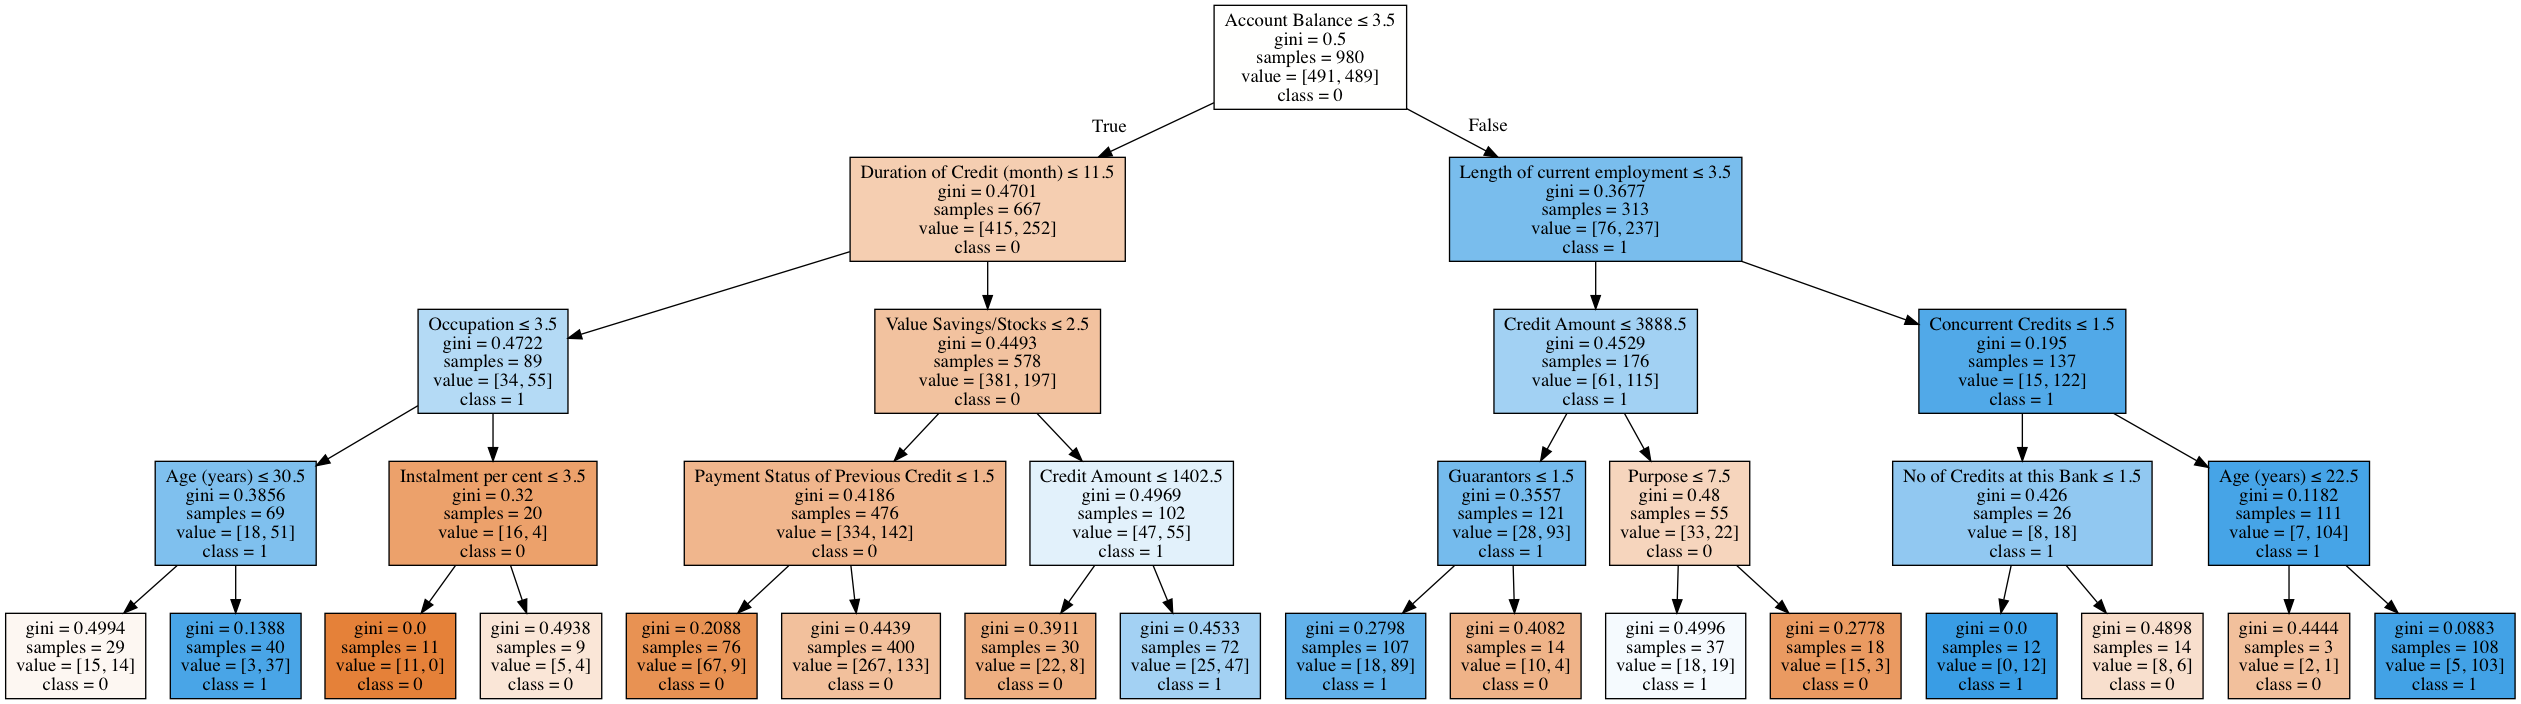

In [76]:
graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out")  
Image(graph.create_png())  

Account Balance <= 3.5

Как я увидел из описания, Account Balance признак отвечаюющий количеству денег из интервала:

1 -> <100DM

2 -> 100DM<= ... < 500DM, 

3 -> 500DM<= ... < 1000DM,

4 -> >= 1000DM

Тогда логично, что кредит лучше выдавать людям с большим счётом (больше надежды, что они его вернут).

Duration of Credit (month) <= 11.5 - очевидно, что означает этот признак

Логично, что мы скорее выдадим кредит на не очень большой период, чем на очень большой срок.

Length of current employment <= 3.5 - также очевидно, что означает этот признак

Если посомотреть дальше на структуру дерева при ответах True и False в этом узле, то видно, что мы выдаём небольшие кредиты тем, у кого небольшой опыт работы, в то же время выдаём кредиты тем, у кого большой стаж и уже взято немного кредитов, либо им > 22.5 лет

In [39]:
cross_val_score(model, X_resampled, y_resampled, n_jobs=-1, cv=10)

array([ 0.62142857,  0.7       ,  0.72857143,  0.77142857,  0.73571429,
        0.67857143,  0.79285714,  0.7       ,  0.5       ,  0.71428571])

In [57]:
accuracy = []
for depth in range(1, 25):
    model = tree.DecisionTreeClassifier(max_depth=depth)
    accuracy.append(np.mean(cross_val_score(model, X_resampled, y_resampled, n_jobs=-1, cv=10)))

In [58]:
accuracy

[0.6785714285714286,
 0.67642857142857138,
 0.69428571428571428,
 0.70500000000000007,
 0.71142857142857152,
 0.73928571428571421,
 0.75857142857142856,
 0.7628571428571429,
 0.76428571428571435,
 0.78642857142857148,
 0.79928571428571427,
 0.80500000000000005,
 0.81142857142857161,
 0.82214285714285718,
 0.82928571428571429,
 0.83142857142857152,
 0.83857142857142863,
 0.83928571428571419,
 0.83714285714285719,
 0.83214285714285707,
 0.83857142857142863,
 0.84428571428571431,
 0.84214285714285708,
 0.84357142857142864]

[]

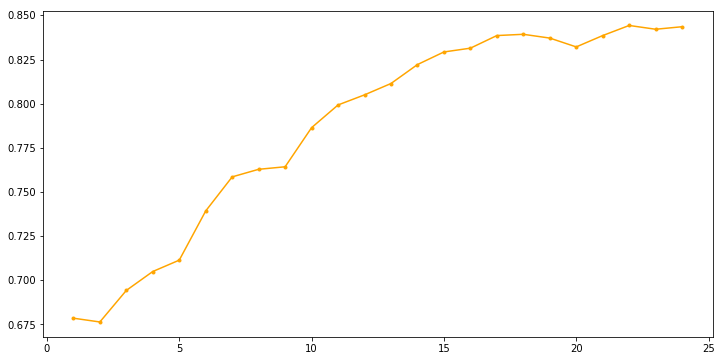

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 25), accuracy, color="orange", marker='.')
plt.plot()